In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

### load fortran rk4 results

In [5]:
a = pd.read_csv('fort.16', delim_whitespace=True, 
                header=None, names=['a_w', 'a_bu', 'a_bs'])
a_w = a.a_w.values[::-1]
a_bu = a.a_bu.values[::-1]
a_bs = a.a_bs.values[::-1]

tlm = pd.read_csv('fort.15', delim_whitespace=True, 
                header=None, names=['tlm_w', 'tlm_bu', 'tlm_bs'])
tlm_w = tlm.tlm_w.values
tlm_bu = tlm.tlm_bu.values
tlm_bs = tlm.tlm_bs.values

nlm = pd.read_csv('fort.14', delim_whitespace=True, 
                header=None, names=['nlm_w', 'nlm_bu', 'nlm_bs'])
w_nlm = nlm.nlm_w.values
bu_nlm = nlm.nlm_bu.values
bs_nlm = nlm.nlm_bs.values

### analytical soluton

In [3]:
def dry_solution(IC, t1, t2, dt=0.1, prc=np.float64):
    """ IC = (w0, bu0, bs0) tuple
        we don't need dt, because t1 and t2 would be index instead of the actual time"""
    nt_func = t2-t1
    t = np.arange(nt_func)*dt
    
    w = np.zeros(nt_func,dtype=prc)
    bu = np.zeros(nt_func,dtype=prc)
    bs = np.zeros(nt_func,dtype=prc)
    
    w[0], bu[0], bs[0] = IC
    
    bu = bu[0]*np.cos(Nu*t) - Nu*w[0]*np.sin(Nu*t)
    w = w[0]*np.cos(Nu*t) + 1/Nu * bu[0]*np.sin(Nu*t)
    bs = (bs[0] - (Ns**2/Nu**2)*bu[0]) + (Ns**2/Nu**2)*bu[0]*np.cos(Nu*t) - (Ns**2/Nu)*w[0]*np.sin(Nu*t)
    
    M =  (1/Nu**2 * bu - 1/Ns**2 * bs).astype(np.float64)
    
    return w, bu, bs, M

def moist_solution(IC, t1, t2, prc=np.float64, dt=0.1):
    """ IC = (w0, bu0, bs0) tuple"""
    nt_func = t2-t1
    t = np.arange(nt_func)*dt
    
    w = np.zeros(nt_func,dtype=prc)
    bu = np.zeros(nt_func,dtype=prc)
    bs = np.zeros(nt_func,dtype=prc)
    
    w[0], bu[0], bs[0] = IC
    
    bs = bs[0]*np.cos(Ns*t) - Ns*w[0]*np.sin(Ns*t)
    w = w[0]*np.cos(Ns*t) + 1/Ns * bs[0]*np.sin(Ns*t)
    bu = (bu[0] - (Nu**2/Ns**2)*bs[0]) + (Nu**2/Ns**2)*bs[0]*np.cos(Ns*t) - (Nu**2/Ns)*w[0]*np.sin(Ns*t)
    
    M =  (1/Nu**2 * bu - 1/Ns**2 * bs).astype(np.float64)
    
    return w, bu, bs, M

[0, 1637, 7390, 10664, 16417, 19691, 25444, 28718, 34471]
[1637 5753 3274 5753 3274 5753 3274 5753]


Text(0.5, 1.0, 'numerical solution')

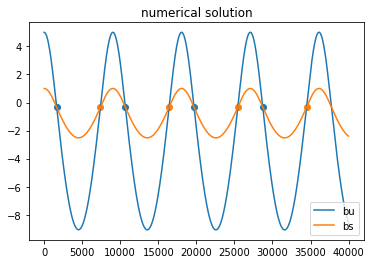

In [6]:
# initialize the Adam-Bashforth nonlinear model
nt = 40000
nt_global = nt
dt = 0.1
Nu = 0.01
Ns = Nu/2

ic_nlm = (0.1, 5, 1)
# ic_tlm = (0.01, 0.01, 0.01)

# traj_nlm = NLM_ab(ic_nlm, nt)
# w_nlm, bu_nlm, bs_nlm = traj_nlm
#w_tlab, bu_tlab, bs_tlab = TLM_ab(ic_tlm, traj_nlm, nt)

# determine the switch point in analytical solution
a = np.where(bu_nlm>bs_nlm)[0]
b = np.where((a[1:]- a[:-1])>1)[0] #counting the ones on the right 1st, 3rd, 5th, .. intersection
idx_its = sorted([0] + a[b].tolist() + a[b+1].tolist())
print(idx_its)
print(np.array(idx_its[1:])-np.array(idx_its[:-1]))

plt.plot(bu_nlm, label='bu')
plt.plot(bs_nlm, label='bs')
plt.scatter(a[b][:5],bu_nlm[a[b][:5]])
plt.scatter(a[b[:4]+1],bu_nlm[a[b[:4]+1]])
plt.legend()
plt.title("numerical solution")

### calculate analytical solution

In [7]:
nt_dry = 3300
nt_sat = 6000
nt_ana = 0
flag = 0 # 0 for dry, 1 for moist
t_st = 0
t_ed = 1700

# w0 = 0.1
# bu0 = 0.5
# bs0 = 0.1
w0, bu0, bs0 = ic_nlm
#nt_global = 200

bu_ana = []
bs_ana = []
w_ana = []

# [t0,t1), [t1,t2) 
while nt_ana <= nt_global:
    print(t_st, t_ed, t_ed-t_st)
    if flag == 0:
        # if t_st == 0:
        w_d, bu_d, bs_d, M = dry_solution((w0, bu0, bs0), t_st, t_ed)

        # else:
        #     w_d, bu_d, bs_d, M = dry_solution((w0, bu0, bs0), t_st, t_ed, )
        rcd_idx = 5+np.where(bu_d[5:]<=bs_d[5:])[0][0]
        nt_ana += rcd_idx-1
        t_st = nt_ana+1
        t_ed = t_st + nt_sat

        bu0 =(bu_d[rcd_idx-1]+bu_d[rcd_idx])/2
        bs0 =(bs_d[rcd_idx-1]+bs_d[rcd_idx])/2
        w0 =(w_d[rcd_idx-1]+w_d[rcd_idx])/2
        
        # bu0 = bu_fx
        # bs0 = bs_fx
        # w0 = w_fx_d2m
        
        bu_ana += bu_d[:rcd_idx].tolist()
        bs_ana += bs_d[:rcd_idx].tolist()
        w_ana += w_d[:rcd_idx].tolist()
        
        flag = 1
        
    else:
        w_s, bu_s, bs_s, M = moist_solution((w0, bu0, bs0), t_st, t_ed)
        rcd_idx = 5+np.where(bs_s[5:]<=bu_s[5:])[0][0]
        nt_ana += rcd_idx-1
        t_st = nt_ana+1
        t_ed = t_st + nt_dry
        
        bu0 =(bu_s[rcd_idx-1]+bu_s[rcd_idx])/2
        bs0 =(bs_s[rcd_idx-1]+bs_s[rcd_idx])/2
        w0 =(w_s[rcd_idx-1]+w_s[rcd_idx])/2
        
        # bu0 = bu_fx
        # bs0 = bs_fx
        # w0 = w_fx_m2d
        
        bu_ana += bu_s[:rcd_idx].tolist()
        bs_ana += bs_s[:rcd_idx].tolist()
        w_ana += w_s[:rcd_idx].tolist()

        flag = 0

0 1700 1700
1638 7638 6000
7389 10689 3300
10664 16664 6000
16415 19715 3300
19689 25689 6000
25441 28741 3300
28715 34715 6000
34467 37767 3300
37741 43741 6000


In [8]:
filled_marker_style1 = dict(marker='o', markersize=5,
                           markerfacecolor='none',
                           markeredgecolor='brown')

filled_marker_style2 = dict(marker='o', markersize=5,
                           markerfacecolor='none',
                           markeredgecolor='darkgreen')

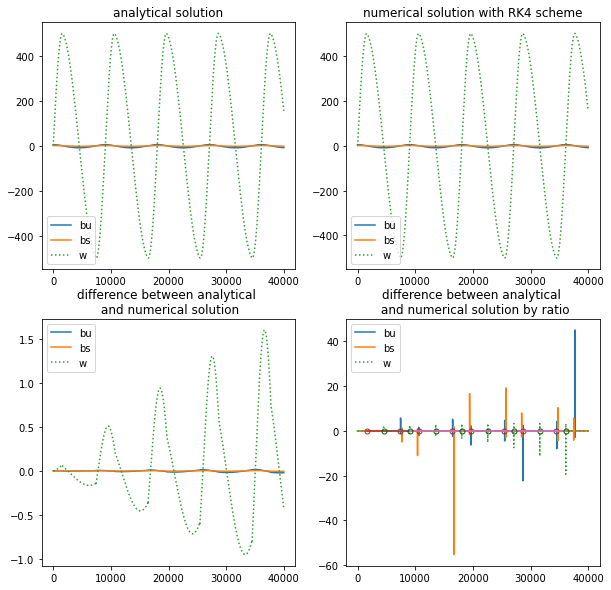

In [20]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
ax[0,0].plot(bu_ana[:nt_global], label='bu')
ax[0,0].plot(bs_ana[:nt_global], label='bs')
ax[0,0].plot(w_ana[:nt_global], label='w', linestyle=':')
ax[0,0].legend()
ax[0,0].set_title("analytical solution")

ax[0,1].plot(bu_nlm, label='bu')
ax[0,1].plot(bs_nlm, label='bs')
ax[0,1].plot(w_nlm, label='w', linestyle=':')
ax[0,1].set_title("numerical solution with RK4 scheme")
ax[0,1].legend()

nt_fort = len(bu_nlm)

ax[1,0].plot(bu_nlm[:nt_fort] - bu_ana[:nt_fort], label='bu')
ax[1,0].plot(bs_nlm[:nt_fort] - bs_ana[:nt_fort], label='bs')
ax[1,0].plot(w_nlm[:nt_fort] - w_ana[:nt_fort], label='w', linestyle=':')
ax[1,0].set_title(f"difference between analytical \n and numerical solution")
ax[1,0].legend()

ax[1,1].plot((bu_nlm[:nt_fort] - bu_ana[:nt_fort])/bu_ana[:nt_fort], label='bu')
ax[1,1].plot((bs_nlm[:nt_fort] - bs_ana[:nt_fort])/bs_ana[:nt_fort], label='bs')
ax[1,1].plot((w_nlm[:nt_fort] - w_ana[:nt_fort])/w_ana[:nt_fort], label='w', linestyle=':')
ax[1,1].set_title(f"difference between analytical \n and numerical solution by ratio")
ax[1,1].legend()

# ax[1,1].plot((bu_nlm - bu_ana[:nt_global])/bu_nlm, label='bu')
# ax[1,1].plot((bs_nlm - bs_ana[:nt_global])/bs_nlm, label='bs')
# ax[1,1].plot((w_nlm - w_ana[:nt_global])/w_nlm, label='w', linestyle=':')
# ax[1,1].set_title(f"difference between analytical \n and numerical solution by ratio")
# ax[1,1].legend()

a = np.where(bu_nlm>bs_nlm)[0]
b = np.where((a[1:]- a[:-1])>1)[0] #counting the ones on the right 1st, 3rd, 5th, .. intersection
c = np.where(w_nlm>0)[0]
d = np.where((c[1:]- c[:-1])>1)[0]

ax[1,1].plot(a[b][:5],np.zeros(4), fillstyle='none', **filled_marker_style1)
ax[1,1].plot(a[b[:4]+1],np.zeros(4), fillstyle='none', **filled_marker_style1)

ax[1,1].plot(c[d][:5],np.zeros(4), fillstyle='none', **filled_marker_style2)
ax[1,1].plot(c[d[:4]+1],np.zeros(4), fillstyle='none', **filled_marker_style2)


# ax[1,1].set_ylim(-40,40)
#plt.savefig("ana_ab.png", format='png',bbox_iches='tight')

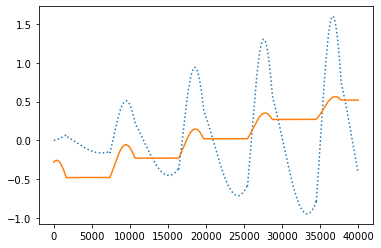

In [19]:
plt.plot((w_nlm[:nt_fort] - w_ana[:nt_fort]), label='w', linestyle=':')
plt.plot((a_bu-a_bu.mean())/np.max(-a_bu))